In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:
import elfi
import pylfire

 /Users/umvremes/anaconda/envs/bonfire_new/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
 /Users/umvremes/anaconda/envs/bonfire_new/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).


# LFIRE

posterior estimation setup:

In [4]:
params_grid=np.linspace(0,3,31)
nsim=100

simulator:

In [5]:
sys.path.append('/Users/umvremes/multitasking-driving/model-infer')
import driver

test setup:

In [6]:
learn_transitions = 100
start_temp = 0.1
learn_time = 1000
target_temp = 0.001

In [7]:
max_pre=3

In [8]:
def driver_generator(sigma, batch_size = 1, random_state = None):
    data = []
    for speed in [17,33]:
        d = driver.driver(speed, sigma)
        d.learn_transitions(iters = learn_transitions)
        d.q = np.load("driver-pre-{:.1f}-{}.npy".format(np.minimum(sigma,max_pre),speed), allow_pickle=True).item()
        d.softmax_temp = start_temp
        d.learn_model(learn_time, anneal_softmax_temp_target = target_temp)
        d_learning = False
        d.log_p = True
        d.log_as_array = True
        d.softmax_temp = target_temp
        d.clear()    
        d.learn_model(300)
        data.append(d.log)
    return data

sum stats:

In [9]:
def offset_std_60(data):
    return np.std(data[:,0],axis=1)

def offset_std_120(data):
    return np.std(data[:,1],axis=1)

elfi model:

In [10]:
import scipy.stats as ss

In [11]:
m=elfi.new_model()
sigma = elfi.Prior(ss.gamma, 3, 0, 0.5, model=m)
Y = elfi.Simulator(elfi.tools.vectorize(driver_generator), sigma)
S1 = elfi.Summary(offset_std_60, Y)
S2 = elfi.Summary(offset_std_120, Y)

about sum stats:

In [12]:
import GPy

In [13]:
ss_kernel=GPy.kern.RBF(input_dim=2, ARD=True)
ss_kernel.lengthscale=0.5

LFIRE:

In [14]:
from pylfire.methods.lfire import LFIRE

In [15]:
from pylfire.classifiers.classifier import GPClassifier

In [16]:
cls=GPClassifier(kernel=ss_kernel)

until here what we did is identical to what we would do when we do not have a pretrained posterior model

but now we initialise with pretrained data:

In [17]:
pre_filename='driver_model_100_300.npz'

In [18]:
%time lfire_method = LFIRE(model=m, classifier=cls, params_grid=params_grid[:,None], batch_size=nsim, precomputed_models=pre_filename)

 /Users/umvremes/anaconda/envs/bonfire_new/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


CPU times: user 16.1 s, sys: 2.54 s, total: 18.6 s
Wall time: 6.55 s


# observed data

load observations:

In [19]:
import csv

In [20]:
data=[]
with open("/Users/umvremes/multitasking-driving/data/practice-out.csv") as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=' ')
    for row in csv_reader: data.append(row)

In [21]:
ids=[d["id"] for d in data]
offset_dict={curid: [[],[]] for curid in np.unique(ids)}

In [22]:
speeds=[int(d["speed"]) for d in data]
speeds=list(np.unique(speeds))

In [23]:
for d in data: offset_dict[d["id"]][speeds.index(int(d["speed"]))].append(float(d["offset"]))

calculate sum stats:

In [24]:
observed_ss=[np.array([np.std(offset_dict[curid][0]),np.std(offset_dict[curid][1])]) for curid in np.unique(ids)]

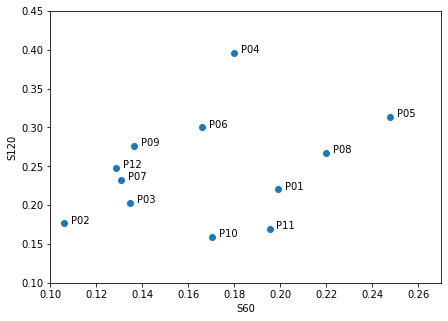

In [25]:
fig=plt.figure(figsize=(7,5))
plt.scatter(np.array(observed_ss)[:,0],np.array(observed_ss)[:,1]);
for i, txt in enumerate(np.unique(ids)):
    plt.annotate(txt, (observed_ss[i][0]+0.003, observed_ss[i][1]))
plt.xlim(0.1,0.27)
plt.ylim(0.1,0.45)
plt.xlabel('S60')
plt.ylabel('S120');

# posterior distributions

evaluate posterior probabilities:

In [26]:
%%time
post_list=[]
for observed in observed_ss:
    post_list.append(lfire_method.infer(observed={'S1': observed[0], 'S2': observed[1]}))

CPU times: user 278 ms, sys: 25.8 ms, total: 304 ms
Wall time: 186 ms


point estimates:

In [27]:
np.set_printoptions(precision=1)
posterior_means=[post.posterior_means['sigma'] for post in post_list]
np.array(posterior_means)

array([1.2, 1.1, 1.1, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.2])

In [28]:
map_estimates=[post.map_estimates['sigma'] for post in post_list]
np.array(map_estimates)

array([1.2, 1.1, 1.2, 1.3, 1.3, 1.2, 1.2, 1.3, 1.3, 1.1, 1.1, 1.3])

examples:

In [29]:
idx=1
post_list[idx].plot_marginals()
plt.title(np.unique(ids)[idx]);

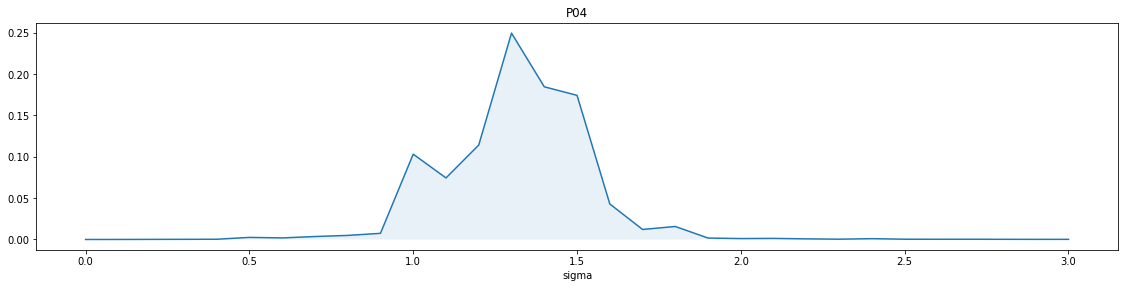

In [30]:
idx=3
post_list[idx].plot_marginals()
plt.title(np.unique(ids)[idx]);

population-level estimate:

In [31]:
np.set_printoptions(precision=2)
observed_ave=np.mean(observed_ss,axis=0)
observed_ave

array([0.17, 0.25])

In [32]:
%time post_ave = lfire_method.infer(observed={'S1': observed_ave[0], 'S2': observed_ave[1]})

CPU times: user 27.6 ms, sys: 3.32 ms, total: 30.9 ms
Wall time: 20.6 ms


In [33]:
post_ave.summary()

Method: LFIRE
Number of simulations: 0
MAP estimates: sigma: 1.3
Posterior means: sigma: 1.21



In [34]:
post_ave.plot_marginals();